# Third Home Assignment

Made by Group 3: <br>
- Diogo Araújo - fc60997 - ?H <br>
- João Braz - fc60419 - ?H <br>
- Joel Oliveira - fc59442 - ?H <br>

In [100]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.cluster import KMeans, OPTICS, cluster_optics_dbscan
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.cluster import (silhouette_score, calinski_harabasz_score, 
                                     silhouette_samples, contingency_matrix, 
                                     homogeneity_score, completeness_score, 
                                     v_measure_score)
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree
from scipy.stats import gaussian_kde
from yellowbrick.cluster import KElbowVisualizer

In [2]:
def drawSillouette(X, labels, header="", ax=None, show_label=True, figsize=(10,4)):
    y_lower =10
    clusters=list(set(labels))
    n_clusters=len(clusters)
    if ax==None:
        fig, ax = plt.subplots(1,1, figsize=figsize)
    ax.set_xlim([-0.5, 1])
    ax.set_ylim([0, len(X) + (n_clusters) * 3+ y_lower])
    sil_avg = silhouette_score(X, labels)
    silhouette_values = silhouette_samples(X, labels)
    for i,c in enumerate(clusters):
        cs_values = silhouette_values[labels == c]
        cs_values.sort()
        size_ci = cs_values.shape[0]
        y_upper = y_lower + size_ci
        color = cm.nipy_spectral(i / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0,  cs_values, facecolor=color, 
                         edgecolor="k", alpha=0.7)
        if show_label:
            ax.text(-0.05, y_lower + 0.5 * size_ci, str(c))
        y_lower = y_upper + 3 
    ax.set_title("Silhouette plot "+ header)
    ax.set_xlabel("Silhouette coefficient")
    ax.set_ylabel("Clusters")
    ax.axvline(x=sil_avg, c="r", linestyle="--")
    ax.set_yticks([]) 

In [3]:
def plot_distance_density(data, dist_func, include_peaks=True, figsize=(6,3)):
    """
    Plots the density of the average distance of the points in the dataset
    """
    dists_avg = dist_func(data).mean(axis=1)
    v,c = np.unique(dists_avg, return_counts=True)
    kde = gaussian_kde(v, weights=c)
    density = kde(v)
    plt.figure(figsize=figsize)
    plt.plot(v, density)
    plt.xlabel("Average Distance")
    plt.ylabel("Density")

In [4]:
def plot_scores(x,y, xlabel="", ylabel="", title="", ax=None):
    if ax==None:
        f, ax = plt.subplots(1,1)
    ax.plot(x,y, "--*")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

In [5]:
def plot_reachability(space, reachibility, X, labels, threshold=None, figsize=(10,3)):
    if threshold==None:
        reach_filter = reachibility<np.inf
    else:
        reach_filter = reachibility<threshold
    filtered_labels = labels[reach_filter]
    filtered_space = space[reach_filter]
    filtered_reach = reachability[reach_filter]
    plt.figure(figsize=figsize)
    colors = ["r", "b", "y", "g", "orange", "c", "m", "purple", "olive", "aqua", "tomato"]
    plt.plot(filtered_space[filtered_labels==-1], filtered_reach[filtered_labels==-1], 
             "k.", alpha=0.2,)
    for k, color in zip(np.unique(labels), colors):
        if k!=-1:
            Xk = filtered_space[filtered_labels==k]
            Rk = filtered_reach[filtered_labels==k]
            plt.plot(Xk, Rk, ".", c=color, alpha=0.2)
    plt.ylabel("Reachability (epsilon distance)")
    plt.title("Reachability Plot")
    plt.grid()

In [6]:
def print_int_statistics(X, model_labels, model_names):
    for labels, name in zip(model_labels, model_names):
        print(name, 
              f"| Silhouette = {silhouette_score(X, labels):.3f} \
| Calinski = {calinski_harabasz_score(X, labels):.3f} \
| Number of clusters = {len(np.unique(labels))}")

# Intrinsic Evaluation

Firstly for each clustering method we will select the best parameters. Afterwards we will make a final selection of wchich one seems to be the one with better clusters

## Train dataset

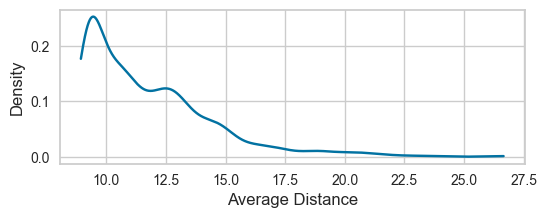

In [143]:
df_dense = pd.read_csv("train.csv").drop(columns="critical_temp")
df_dense = StandardScaler().set_output(transform="pandas").fit_transform(df_dense)
plot_distance_density(df_dense, euclidean_distances, figsize=(6,2))

### Hierarchical Clustering

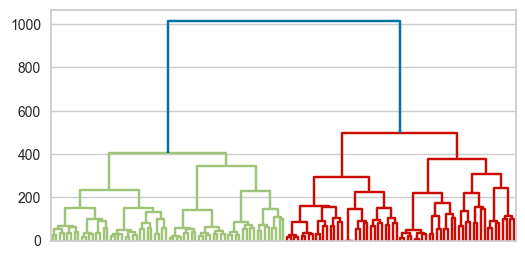

In [11]:
tree_results = linkage(df_dense, method="ward")
_, ax = plt.subplots(1,1, figsize=(6,3))
dendrogram(tree_results, truncate_mode="level", p = 6, no_labels=True, ax=ax );

In [12]:
ward_labels=cut_tree(tree_results, height=390).ravel()

### KMeans

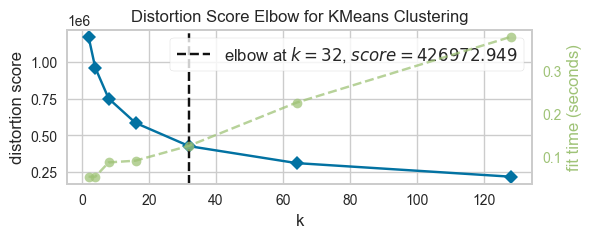

In [146]:
_, ax = plt.subplots(1,1,figsize=(6,2))
KElbowVisualizer(KMeans(n_init="auto", random_state=13),ax=ax, 
                 k=[2<<i for i in range(7)] ).fit(df_dense).show();

In [14]:
kmeans = KMeans(n_clusters=32, n_init="auto", random_state=13).fit(df_dense)

### DBSCAN

In [17]:
opts_dense = OPTICS(min_cluster_size=0.05, min_samples=0.01, n_jobs=-1).fit(df_dense)
space = np.arange(len(df_dense))
reachability = opts_dense.reachability_[opts_dense.ordering_]
labels = opts_dense.labels_[opts_dense.ordering_]

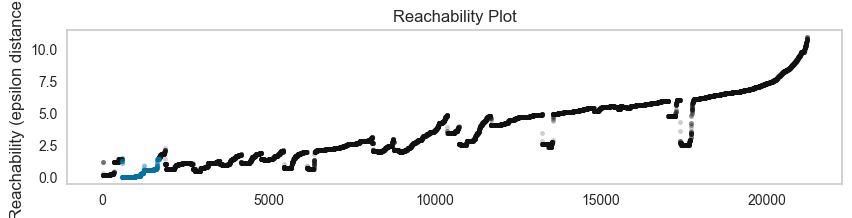

In [18]:
plot_reachability( space, reachability, df_dense, labels, figsize=(10,2))

In [19]:
dbs_labels = cluster_optics_dbscan(
    reachability=opts_dense.reachability_, core_distances=opts_dense.core_distances_,
    ordering=opts_dense.ordering_, eps=3)

### Compare Results

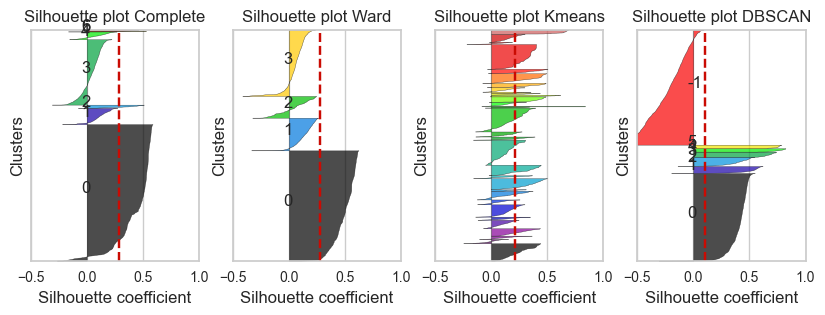

In [26]:
f, ax = plt.subplots(1,4,figsize=(10,3))
drawSillouette(df_dense, ward_labels, "Ward", ax=ax[0])
drawSillouette(df_dense, kmeans.labels_, "Kmeans", ax=ax[1], show_label=False)
drawSillouette(df_dense, dbs_labels, "DBSCAN", ax=ax[2])

In [23]:
print_int_statistics( df_dense, [ward_labels, kmeans.labels_, dbs_labels], ["ward", "kmeans", "dbscan"])

complete | Silhouette = 0.285 | Calinski = 2454.930 | Number of clusters = 7
ward | Silhouette = 0.273 | Calinski = 5114.066 | Number of clusters = 4
kmeans | Silhouette = 0.216 | Calinski = 2077.729 | Number of clusters = 32
dbscan | Silhouette = 0.102 | Calinski = 1685.674 | Number of clusters = 7


## Unique Dataset

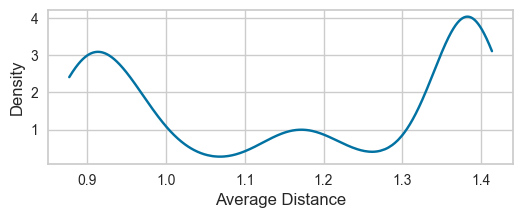

In [144]:
df_sparse = pd.read_csv("unique_m.csv").drop(columns=["material", "critical_temp"])
constant_cols = df_sparse.columns[df_sparse.std()==0]
df_sparse = df_sparse.drop(columns=constant_cols)
df_sparse = Normalizer().set_output(transform="pandas").fit_transform(df_sparse)
plot_distance_density(df_sparse, euclidean_distances, figsize=(6,2))

### Hierarchical Clustering

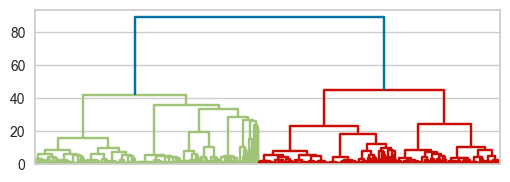

In [103]:
tree_results = linkage(df_sparse, method="ward")
_, ax = plt.subplots(1,1, figsize=(6,2))
dendrogram(tree_results, truncate_mode="level", p=10, no_labels=True, ax=ax);

In [105]:
ward_labels = cut_tree(tree_results, height=40).ravel()

### Kmeans

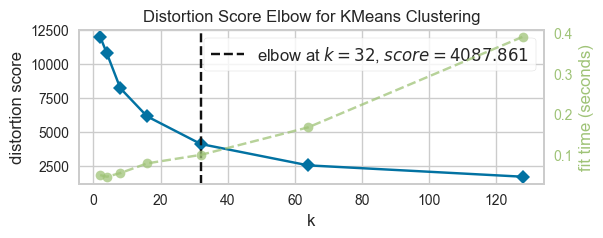

In [145]:
_, ax = plt.subplots(1,1,figsize=(6,2))
KElbowVisualizer(KMeans(n_init="auto", random_state=13),ax=ax, 
                 k=[2<<i for i in range(7)] ).fit(df_sparse).show();

In [107]:
kmeans=KMeans(n_clusters=32, n_init="auto", random_state=13).fit(df_sparse)

### DBSCAN

In [108]:
opts_sparse = OPTICS(min_cluster_size=0.05, min_samples=0.02, n_jobs=-1).fit(df_sparse)
space = np.arange(len(df_sparse))
reachability = opts_sparse.reachability_[opts_sparse.ordering_]
labels = opts_sparse.labels_[opts_sparse.ordering_]

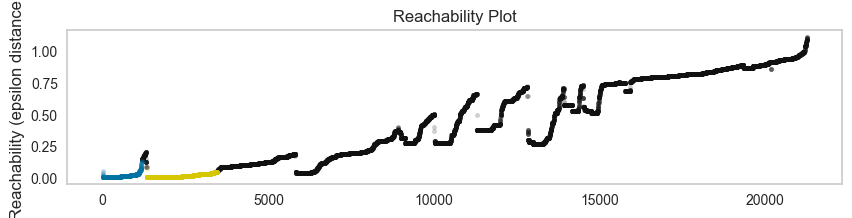

In [109]:
plot_reachability( space, reachability, df_sparse, labels, figsize=(10,2))

In [117]:
dbs_labels = cluster_optics_dbscan(
    reachability=opts_sparse.reachability_, core_distances=opts_sparse.core_distances_,
    ordering=opts_sparse.ordering_, eps=.5
)

### Compare Results

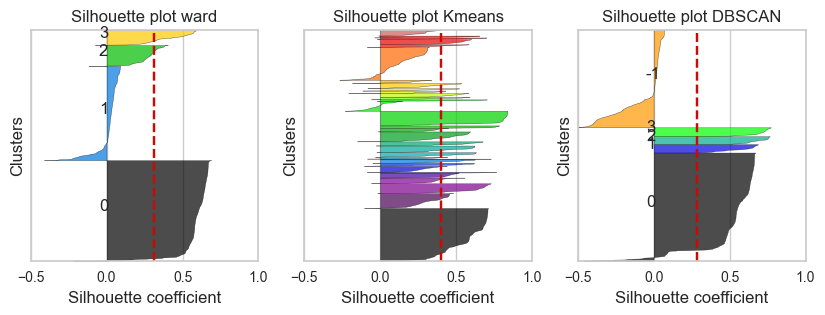

In [120]:
f, ax = plt.subplots(1,3,figsize=(10,3))
drawSillouette(df_sparse, ward_labels, "ward", ax=ax[0])
drawSillouette(df_sparse, kmeans.labels_, "Kmeans", ax=ax[1], show_label=False)
drawSillouette(df_sparse, dbs_labels, "DBSCAN", ax=ax[2])

In [121]:
print_int_statistics(
    df_sparse, 
    [ward_labels, kmeans.labels_, dbs_labels],
    ["ward", "kmeans", "dbscan"])

ward | Silhouette = 0.314 | Calinski = 4054.139 | Number of clusters = 4
kmeans | Silhouette = 0.399 | Calinski = 2002.241 | Number of clusters = 32
dbscan | Silhouette = 0.286 | Calinski = 2928.424 | Number of clusters = 5


# Extrinsic Evaluation

- Best Model for `train` dataset $\rightarrow$ DBSCAN
- Best Model for `unique` dataset $\rightarrow$ Ward Linkage

We will evaluate the models selected from intrisic statistics and see how they perform using extrinsic methods. <br>
We will also compare the results with the **ground truth** and the **random assignement** of a label


In [123]:
def to_class(x):
    if 0<=x<1:
        return 0
    if x<5:
        return 1
    if x<20:
        return 2
    if x<100:
        return 3
    return 4

In [124]:
def contengency_matrix(y, labels):
    return pd.DataFrame(
        data=contingency_matrix(y, labels),
        columns=np.unique(labels),
        index=np.unique(y)
    )

In [125]:
def print_ext_statistics(y, labels):
    print(f"Homogeneity = {homogeneity_score(y, labels):.3f} | \
Completeness = {completeness_score(y, labels):.3f} | \
V-Measure = {v_measure_score(y, labels):.3f}")

In [126]:
y = pd.read_csv("train.csv")["critical_temp"].apply(to_class)

In [142]:
print_int_statistics(df_sparse, [y], ["ground truth"])
print_int_statistics(df_dense, [y], ["ground truth"])

ground truth | Silhouette = 0.002 | Calinski = 1019.975 | Number of clusters = 5
ground truth | Silhouette = -0.002 | Calinski = 1615.781 | Number of clusters = 5


For both the sparse and the dense datasets the silhouette results that were obtained are very bad. This could mean that the classes are not well clustered and very sparse and overlapping and/or the transformations performed on the data were not the most suitable. 

In [133]:
dense_labels =  dbs_labels = cluster_optics_dbscan(
    reachability=opts_dense.reachability_,
    core_distances=opts_dense.core_distances_,
    ordering=opts_dense.ordering_,
    eps=3
)
sparse_labels = cut_tree(linkage(df_sparse, method="ward"), height=40).ravel()
random_labels = np.random.randint(y.nunique(), size=len(y))

In [138]:
print_ext_statistics(y, dense_labels)
print_ext_statistics(y, sparse_labels)
print_ext_statistics(y, random_labels)

Homogeneity = 0.253 | Completeness = 0.282 | V-Measure = 0.267
Homogeneity = 0.278 | Completeness = 0.319 | V-Measure = 0.297
Homogeneity = 0.000 | Completeness = 0.000 | V-Measure = 0.000


We can see that random assignment has way worse results than the labeling created by the clusters. This means that although the model was not created with any information about the real classes it could capture some meaning from the data.

In [129]:
contengency_matrix(y, dense_labels)

,-1,0,1,2,3,4,5
0,984,12,0,2,0,1,2
1,3837,79,0,5,21,13,63
2,3989,932,17,49,241,84,256
3,1601,6647,613,590,205,218,0
4,182,403,12,205,0,0,0


From the contengency matrix above we can see that a lot of the samples are considered noise. 

In [130]:
contengency_matrix(y, sparse_labels)

,0,1,2,3
0,81,864,49,7
1,279,3591,24,124
2,1213,3673,90,592
3,7210,549,1427,688
4,473,1,328,0


On the 